# Text mining project - SEC 8-K for Stock Price Forecasting

## Import & preprocessing

In [85]:
# Disable jedi to make autocompletion much faster
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings('ignore')

First, we import the data, which comes with adjusted ppc (price percent change) into a dataframe

In [1]:
import pandas as pd
import numpy as np
# Stock price history
alpha_df = pd.read_csv('./data/alphavantage.csv')
# S&P500 history
sp500_df = pd.read_csv('./data/sp500_hist.csv')
# SEC 8-K forms
sec8_series = pd.read_json("./data/preprocessed_sec8_filings.json")['data']
sec8_df_raw = pd.DataFrame(sec8_series.sum())
sec8_df_raw = sec8_df_raw.dropna().reset_index()
sec8_df = sec8_df_raw.copy()
sec8_df.drop(["index", "cik"], axis=1, inplace=True)
sec8_df.head()

,ticker,sec_filing_date,text,target_day1open_day1close_ppc,target_day1open_day2close_ppc,target_day1open_day3close_ppc,target_dayneg1close_day1open_ppc
0,AIT,2017-01-13 00:00:00,0000109563-17-000018.txt : 20170113 0000109563...,-0.007612,0.011033,0.012198,0.006320
1,AIT,2017-01-26 00:00:00,0000109563-17-000036.txt : 20170126 0000109563...,-0.026110,-0.035664,-0.051111,0.000495
2,AIT,2017-03-02 00:00:00,0000109563-17-000062.txt : 20170302 0000109563...,-0.003292,-0.005536,-0.008944,-0.013831
3,AIT,2017-04-27 00:00:00,0000109563-17-000074.txt : 20170427 0000109563...,-0.042239,-0.047690,-0.039190,0.044192
4,AIT,2017-05-15 00:00:00,0000109563-17-000080.txt : 20170515 0000109563...,-0.005644,-0.024592,-0.021755,0.003241


## Baseline features: yesterday's performance
We add yesterday's performance as a feature to calculate a baseline.

In [2]:
%%time
sp500_df.Datum = pd.to_datetime(sp500_df.Datum)
sp500_df = sp500_df.sort_values("Datum")
sp500_df.columns = ["date", "close", "volume", "open", "high", "low"]

# Go through each ticker and date for the filings, and calculate the adjusted ppc from the day before the filing
# If no data exists the day before, take the latest day
sec8_df['feature_ppc_dayneg1'] = np.nan
alpha_df.date = alpha_df.date.apply(pd.to_datetime)

for index, row in sec8_df.iterrows():
    ticker, date = row['ticker'], row['sec_filing_date']
    date = pd.to_datetime(date)
    # print(ticker, date)
    # Select rows where date is the day before filing
    sp500_neg1 = sp500_df[sp500_df.date < date].tail(1)
    alpha_neg1 = alpha_df[alpha_df.date < date].tail(1)
    # Only calculate ppc if dates exist on both dfs
    if sp500_neg1.date.iloc[0] == alpha_neg1.date.iloc[0]:
        sp500_ppc = (sp500_neg1.close.iloc[0]-sp500_neg1.open.iloc[0])/sp500_neg1.open.iloc[0]
        alpha_ppc = (alpha_neg1.close.iloc[0]-alpha_neg1.open.iloc[0])/alpha_neg1.open.iloc[0]
        ppc = alpha_ppc - sp500_ppc
        sec8_df.loc[(sec8_df.sec_filing_date == str(date)) & (sec8_df.ticker == ticker), 'feature_ppc_dayneg1'] = ppc

CPU times: user 5min 37s, sys: 1min 47s, total: 7min 25s
Wall time: 7min 26s


Some of the texts in the data are corrupt or invalid, for example because they weren't properly fetched from the website since the request was rejected, or because they don't contain the events we are looking for. Such is the case with documents with financial tables. We remove all invalid documents. See `helper_functions.py` for functionality.

In [3]:
%run helper_functions.py

invalid_docs = get_invalid_documents(sec8_df)
sec8_df.drop(invalid_docs, inplace=True)
sec8_df = sec8_df.dropna().reset_index()
print(f"Removed {len(invalid_docs)} invalid documents")

Removed 360 invalid documents


**Cleaning**

Let's take a look at a filing:

In [5]:
sec8_df['text'][0]

"0000109563-17-000018.txt : 20170113 0000109563-17-000018.hdr.sgml : 20170113 20170113081754 ACCESSION NUMBER: 0000109563-17-000018 CONFORMED SUBMISSION TYPE: 8-K PUBLIC DOCUMENT COUNT: 1 CONFORMED PERIOD OF REPORT: 20170110 ITEM INFORMATION: Departure of Directors or Certain Officers; Election of Directors; Appointment of Certain Officers: Compensatory Arrangements of Certain Officers FILED AS OF DATE: 20170113 DATE AS OF CHANGE: 20170113 FILER: COMPANY DATA: COMPANY CONFORMED NAME: APPLIED INDUSTRIAL TECHNOLOGIES INC CENTRAL INDEX KEY: 0000109563 STANDARD INDUSTRIAL CLASSIFICATION: WHOLESALE-MACHINERY, EQUIPMENT & SUPPLIES [5080] IRS NUMBER: 340117420 STATE OF INCORPORATION: OH FISCAL YEAR END: 0630 FILING VALUES: FORM TYPE: 8-K SEC ACT: 1934 Act SEC FILE NUMBER: 001-02299 FILM NUMBER: 17526527 BUSINESS ADDRESS: STREET 1: ONE APPLIED PLAZA CITY: CLEVELAND STATE: OH ZIP: 44115-5056 BUSINESS PHONE: 216-426-4753 MAIL ADDRESS: STREET 1: ONE APPLIED PLAZA CITY: CLEVELAND STATE: OH ZIP: 44

---
The only information from this filing is actually the text `John F. Meier, a director of Applied Industrial Technologies, Inc. (“Applied”) since 2005, age 69, retired from the Board of Directors on January 10, 2017. Mr. Meier’s retirement was for personal reasons and did not result from any disagreement with Applied.`

In other words, large parts of the documents we don't care about. We extract only the information from the texts with some regex magic:

In [6]:
%%time
sec8_df['text'] = sec8_df['text'].apply(extract_8k)
sec8_df['text'][0]

CPU times: user 37.4 s, sys: 183 ms, total: 37.5 s
Wall time: 37.7 s


'DEPARTURE OF DIRECTORS OR CERTAIN OFFICERS; ELECTION OF DIRECTORS; APPOINTMENT OF CERTAIN OFFICERS; COMPENSATORY ARRANGEMENTS OF CERTAIN OFFICERS. John F. Meier, a director of Applied Industrial Technologies, Inc. (“Applied”) since 2005, age 69, retired from the Board of Directors on January 10, 2017. Mr. Meier’s retirement was for personal reasons and did not result from any disagreement with Applied.'

We managed to extract only the relevant part of the text.

The distribution of number of words in the corpus is as follows:

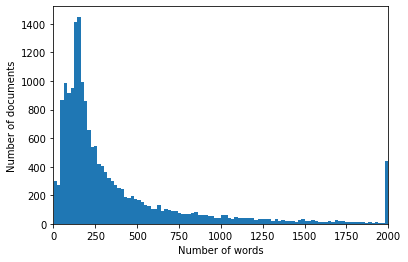

In [357]:
lengths = []
for j in range(len(sec8_df)):
    lengths.append(len(sec8_df['text'][j].split()))
lengths = np.array(lengths)

import matplotlib.pyplot as plt
_ = plt.hist(lengths, bins=100)  # arguments are passed to np.histogram
plt.xlim([0, 2000])
plt.xlabel("Number of words")
plt.ylabel("Number of documents")
plt.show()

Let's clean up the text a bit - we lemmatize, remove numeric values, and remove any 1 letter words.
Also, we assume that the most important text is in the beginning, so we truncate each text to 500 words.

In [7]:
import spacy
nlp = spacy.load('en_core_web_lg', disable='parser')
MAX_SEQ_LEN = 500

def preprocess(text):
    if len(text.split()) > MAX_SEQ_LEN*2:
        text = ' '.join(text.split()[:MAX_SEQ_LEN*2])
    processed = [token.lemma_ for token in nlp(text) if token.lemma_.isalpha() and len(token.lemma_) > 1]
    if len(processed) > MAX_SEQ_LEN:
        return ' '.join(processed[:MAX_SEQ_LEN])
    return ' '.join(processed)

Preprocess all data by using our preprocessing function on the text, as well as converting numerical targets to {"UP", "DOWN"}:

In [7]:
%%time
label_dict = {
    "DOWN": 0,
    "UP": 1
}
def conv_col_to_cat(df, col):
    # Converts a column in dataframe with numerical targets to categorical
    df_new = df.copy()
    df_new.loc[df[col] > 0, col] = label_dict["UP"]
    df_new.loc[df[col] <= 0, col] = label_dict["DOWN"]
    df_new[col] = df_new[col].astype(int)
    return df_new


load_from_file = True

if load_from_file:
    sec8_df = pd.read_csv("data/processed_df.csv")
    sec8_df = sec8_df.drop(columns = list(sec8_df.columns[:2]))
    sec8_df = sec8_df.dropna().reset_index(drop=True)
else:
    sec8_df['text'] = sec8_df['text'].apply(preprocess)
    sec8_df = conv_col_to_cat(sec8_df, 'target_day1open_day1close_ppc')
    sec8_df = conv_col_to_cat(sec8_df, 'target_day1open_day2close_ppc')
    sec8_df = conv_col_to_cat(sec8_df, 'target_day1open_day3close_ppc')
    sec8_df = conv_col_to_cat(sec8_df, 'target_dayneg1close_day1open_ppc')
    sec8_df = conv_col_to_cat(sec8_df, 'feature_ppc_dayneg1')
    sec8_df.to_csv("data/processed_df.csv")

CPU times: user 271 ms, sys: 40 ms, total: 311 ms
Wall time: 320 ms


In [10]:
sec8_df.loc[0, 'text']

'departure of director or certain officer election of director appointment of certain officer compensatory arrangement of certain officer John Meier director of Applied Industrial Technologies Applied since age retire from the Board of Directors on January Meier retirement be for personal reason and do not result from any disagreement with Applied'

## Train/val/test split

In [34]:
from pandas import to_datetime as to_dt

# Train/val/test split
dates = to_dt(sec8_df['sec_filing_date'])

train_idx = sec8_df.loc[dates <= to_dt("2019-06-01")].index
val_idx = sec8_df.loc[(dates > to_dt("2019-06-01")) & (dates <= to_dt("2020-06-01"))].index
test_idx = sec8_df.loc[(dates > to_dt("2020-06-01"))].index

# Print statistics in data
n_words_train = sum([len(text.split()) for text in sec8_df.loc[train_idx, 'text']])
n_words_val = sum([len(text.split()) for text in sec8_df.loc[val_idx, 'text']])
n_words_test = sum([len(text.split()) for text in sec8_df.loc[test_idx, 'text']])
print(f"{len(train_idx)} filings and {n_words_train} words in training set")
print(f"{len(val_idx)} filings and {n_words_val} words in validation set")
print(f"{len(test_idx)} filing and {n_words_test} words in test set")
print(f"Average filing word count: {round((n_words_train + n_words_val + n_words_test)/(len(train_idx)+len(val_idx)+len(test_idx)))}")

9836 filings and 3548939 words in training set
4239 filings and 1632374 words in validation set
3877 filing and 1573690 words in test set
Average filing word count: 376


## Feature extraction

Time to extract features: we start by converting texts to sequences of integer, then zero-padding to the same length.

In [116]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = sec8_df['text']
X_bl = sec8_df['feature_ppc_dayneg1'] # Feature for baseline 
y = sec8_df.loc[:, ['target_day1open_day1close_ppc', 
                'target_day1open_day2close_ppc', 
                'target_day1open_day3close_ppc', 
                'target_dayneg1close_day1open_ppc']]
y.columns = ['n0', 'n1', 'n2', 'n3']
y_train = y.iloc[train_idx]
y_val = y.iloc[val_idx]
y_test = y.iloc[test_idx]

tokenizer = Tokenizer()
# Fit tokenizer to training texts
tokenizer.fit_on_texts(X.iloc[train_idx])

word_index = tokenizer.word_index
VOCAB_SIZE = len(tokenizer.word_index)

# Convert texts to index sequences
X_train = tokenizer.texts_to_sequences(X.iloc[train_idx])
X_val = tokenizer.texts_to_sequences(X.iloc[val_idx])
X_test = tokenizer.texts_to_sequences(X.iloc[test_idx])
# Pad the sequences
MAX_SEQ_LEN = 500
X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")
X_val = pad_sequences(X_val, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")
X_test = pad_sequences(X_test, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")

inverse_word_index = {word_index[key]: key for key in word_index.keys()}
inverse_word_index[0] = "<>"

Let's see what we have to work with:

In [35]:
print(X_train.shape)
print(y.iloc[train_idx].shape)

(9836, 500)
(9836, 4)


So our input features are all of dimension 500 and we have 4 target variables.

## Class distribution:

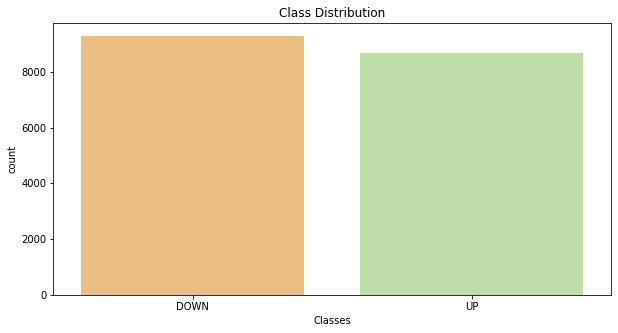

In [395]:
import seaborn as sns
import matplotlib.pyplot as plt

#plot class distribution
plt.figure(figsize=(10, 5))
sns.countplot(y.n0, palette='Spectral')
plt.xlabel('Classes')
plt.xticks([label_dict["DOWN"],label_dict["UP"]], ["DOWN", "UP"])
plt.title('Class Distribution');

## Baseline performance
As a simple baseline, we use the price percent change for the previous day of the sec filing day from open to close, in addition to a random and majority classifier

In [469]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score


model_majority = DummyClassifier(strategy="prior")
model_uni = DummyClassifier(strategy="uniform")
acc_majority = {}
acc_uni = {}
acc_bl = {}
for day in ["n0", "n1", "n2", "n3"]:    
    model_majority.fit(X_train, y_train[day])
    model_uni.fit(X_train, y_train[day])
    y_pred_majority = model_majority.predict(X_test)
    y_pred_uni = model_uni.predict(X_test)
    acc_majority[day] = accuracy_score(y_test[day], y_pred_majority)
    acc_uni[day] = accuracy_score(y_test[day], y_pred_uni)
    acc_bl[day] = accuracy_score(y_test[day], X_bl.iloc[test_idx])

print("Majority classifier: ", acc_majority)
print("Uniform random classifier:", acc_uni)
print("Baseline classifier:", acc_bl)

Majority classifier:  {'n0': 0.5424297136961568, 'n1': 0.5406241939644054, 'n2': 0.5331441836471499, 'n3': 0.5318545266958989}
Uniform random classifier: {'n0': 0.501418622646376, 'n1': 0.49935517152437453, 'n2': 0.502708279597627, 'n3': 0.4988393087438741}
Baseline classifier: {'n0': 0.4978075831828734, 'n1': 0.49703378901212275, 'n2': 0.5143151921588858, 'n3': 0.5127676038173846}


## Pretraining the embedding layer

In our model, we use an embedding layer as the first layer, both in order to reduce the dimension of our vocabulary, and to give meaningful vector representations of our words (compared to using unique integers or one-hot encoding). What we mean by "meaningful" in this context is that if there is some relationship between words, this should be reflected in the vectors in space. For example, two vectors embedding similar words could be nearby in space.

We will use the GloVe word embeddings, to avoid having to train the weights of the embedding layer ourselves and hopefully achieve better performance.

In [811]:
%%time
import os
# Pretrain the embedding layer using GloVe
# Code for building embedding matrix from https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
GLOVE_DIR = './data/glove.6B'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.42B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_DIM))
oov_list = []

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        oov_list.append(word)
        
len(oov_list)

Found 1917494 word vectors.
CPU times: user 2min 12s, sys: 5.49 s, total: 2min 17s
Wall time: 2min 21s


1059

Words in the filings that are out-of-vocabulary, i.e. not in GloVe are printed below. 

(From a quick inspection, these do not seem important for the classification task anyway!)

In [831]:
oov_list[:30]

['mplx',
 'calatlantic',
 'exhibitsfinancial',
 'counterpartie',
 'fncb',
 'apeg',
 'inbelow',
 'homebuilde',
 'wectec',
 'prsus',
 'vodafoneziggo',
 'bbld',
 'tcja',
 'essendant',
 'mmbtud',
 'upcic',
 'tegsa',
 'redwitz',
 'bvbc',
 'kreiz',
 'pharmedium',
 'lexpe',
 'fblb',
 'spartannash',
 'zenium',
 'zinsner',
 'hantson',
 'jotec',
 'underbelow',
 'norbe']

## Creating the neural network
Let's create the deep neural network model which uses as the first layer the embedding layer we just created

In [936]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
import keras_tuner as kt

def create_nn_model(lstm_units=64, dense_units=64, dropout=0.3):
    model = keras.models.Sequential()
    embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE+1, 
                               output_dim=EMBEDDING_DIM, 
                               input_length=MAX_SEQ_LEN,
                               weights=[embedding_matrix],
                               mask_zero=True,
                               trainable=False) ## J*MFÖRA MED MED!!
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(units=lstm_units, dropout=dropout, recurrent_dropout=0.3)))
    model.add(layers.Dense(units=dense_units, activation='relu'))
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

print(create_nn_model().summary())

# define the grid search parameters
def build_gridsearch_model(hp):
    dropout = hp.Choice("dropout", [0.2, 0.5, 0.7])
    lstm_units = hp.Choice("lstm_units", [32, 64, 128])
    dense_units = hp.Choice("dense_units", [32, 64, 128])
    model = create_nn_model(lstm_units, dense_units, dropout)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create the tuner which will be used to search over the grid of parameters
tuner = kt.RandomSearch(
    hypermodel=build_gridsearch_model,
    objective="val_accuracy",
    max_trials=10,
    overwrite=True,
    directory="tuning",
    project_name="sec8tuning",
)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 500, 300)          5251200   
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              186880    
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,446,401
Trainable params: 195,201
Non-trainable params: 5,251,200
_________________________________________________________________
None


In [937]:
%%time

# Search for the best parameters
tuner.search(X_train, y_train.n0, epochs=10, validation_data=(X_val, y_val.n0))

Trial 10 Complete [00h 44m 15s]
val_accuracy: 0.5133286118507385

Best val_accuracy So Far: 0.522292971611023
Total elapsed time: 11h 16m 15s
INFO:tensorflow:Oracle triggered exit
CPU times: user 1d 17h 2min 46s, sys: 1d 8min 10s, total: 2d 17h 10min 56s
Wall time: 11h 16min 15s


In [938]:
# Best hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
y_pred = pd.DataFrame(columns=y_train.columns)
models = {}
histories = {}
# Train all models according to the best hyperparameters for day n0
for day in ['n0', 'n1', 'n2', 'n3']:
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train, y_train[day], epochs=10, validation_data=(X_val, y_val[day]))
    models[day] = model
    histories[day] = history
    
    # Test it
    yp = model.predict(X_test)
    y_pred[day] = np.where(yp > 0.5, 1, 0).flatten()

Epoch 1/10
308/308 [==============================] - 321s 1s/step - loss: 0.6961 - accuracy: 0.5072 - val_loss: 0.6963 - val_accuracy: 0.4937
Epoch 2/10
308/308 [==============================] - 312s 1s/step - loss: 0.6933 - accuracy: 0.5117 - val_loss: 0.6932 - val_accuracy: 0.5098
Epoch 3/10
308/308 [==============================] - 311s 1s/step - loss: 0.6907 - accuracy: 0.5255 - val_loss: 0.6939 - val_accuracy: 0.5072
Epoch 4/10
308/308 [==============================] - 312s 1s/step - loss: 0.6859 - accuracy: 0.5425 - val_loss: 0.6960 - val_accuracy: 0.5171
Epoch 5/10
308/308 [==============================] - 313s 1s/step - loss: 0.6801 - accuracy: 0.5574 - val_loss: 0.6993 - val_accuracy: 0.5060
Epoch 6/10
308/308 [==============================] - 341s 1s/step - loss: 0.6684 - accuracy: 0.5797 - val_loss: 0.7119 - val_accuracy: 0.5136
Epoch 7/10
308/308 [==============================] - 363s 1s/step - loss: 0.6538 - accuracy: 0.5995 - val_loss: 0.7180 - val_accuracy: 0.5015

## Save models and histories

In [944]:
import pickle
def save_obj(obj, filename):
    with open("./models/" + filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
save_obj(models, "models.pkl")
save_obj(histories, "histories.pkl")

2022-01-15 09:18:05.048383: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://c8a6ab1b-47b1-458d-9b0f-a20f5e9a735b/assets


INFO:tensorflow:Assets written to: ram://da8dbe17-4e8a-4544-9afb-070768a82554/assets


INFO:tensorflow:Assets written to: ram://da8dbe17-4e8a-4544-9afb-070768a82554/assets


INFO:tensorflow:Assets written to: ram://35dccff1-29cc-4590-ba9a-7f20ef09d677/assets


INFO:tensorflow:Assets written to: ram://35dccff1-29cc-4590-ba9a-7f20ef09d677/assets


INFO:tensorflow:Assets written to: ram://5284b2c8-031d-4a4e-9f46-a92109cba3eb/assets


INFO:tensorflow:Assets written to: ram://5284b2c8-031d-4a4e-9f46-a92109cba3eb/assets


INFO:tensorflow:Assets written to: ram://6ded83a3-22c6-432a-93b1-6f1d4f7ffcab/assets


INFO:tensorflow:Assets written to: ram://6ded83a3-22c6-432a-93b1-6f1d4f7ffcab/assets


INFO:tensorflow:Assets written to: ram://1a17f1ed-e5c9-478b-ae8c-bac9af3020c4/assets


INFO:tensorflow:Assets written to: ram://1a17f1ed-e5c9-478b-ae8c-bac9af3020c4/assets


INFO:tensorflow:Assets written to: ram://0505a11c-9dd4-41d1-a2e6-e9c60d64b12f/assets


INFO:tensorflow:Assets written to: ram://0505a11c-9dd4-41d1-a2e6-e9c60d64b12f/assets


INFO:tensorflow:Assets written to: ram://e60782b1-9eb3-4f0a-99c4-76dd2f5b251e/assets


INFO:tensorflow:Assets written to: ram://e60782b1-9eb3-4f0a-99c4-76dd2f5b251e/assets


## Load saved models and histories

In [91]:
models = pickle.load(open("./models/models.pkl", "rb" ))
histories = pickle.load(open("./models/histories.pkl", "rb" ))

2022-02-20 18:51:23.174871: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Evaluate models

In [118]:
from sklearn.metrics import classification_report
for day, model in models.items():
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print(f"Test accuracy score, day {day}:")
    print(classification_report(y_test[day], np.where(y_pred_test > 0.5, 1, 0)))
    print(f"Training accuracy score, day {day}:")
    print(accuracy_score(y_train[day], np.where(y_pred_train > 0.5, 1, 0)))
    print("")

Test accuracy score, day n0:
              precision    recall  f1-score   support

           0       0.53      0.40      0.46      2103
           1       0.45      0.58      0.51      1774

    accuracy                           0.48      3877
   macro avg       0.49      0.49      0.48      3877
weighted avg       0.49      0.48      0.48      3877

Training accuracy score, day n0:
0.7120780805205368

Test accuracy score, day n1:
              precision    recall  f1-score   support

           0       0.55      0.61      0.57      2096
           1       0.47      0.41      0.44      1781

    accuracy                           0.52      3877
   macro avg       0.51      0.51      0.51      3877
weighted avg       0.51      0.52      0.51      3877

Training accuracy score, day n1:
0.703436356242375

Test accuracy score, day n2:
              precision    recall  f1-score   support

           0       0.53      0.44      0.48      2067
           1       0.46      0.56      0.51  

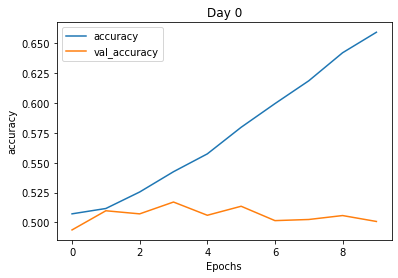

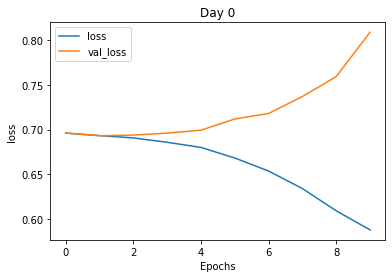

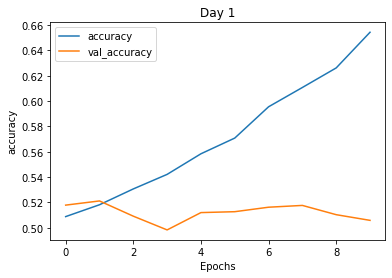

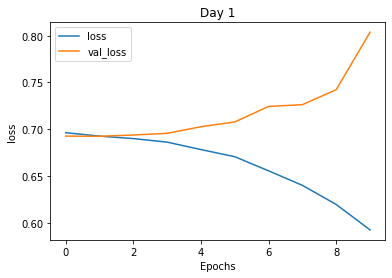

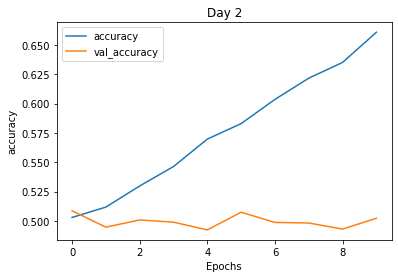

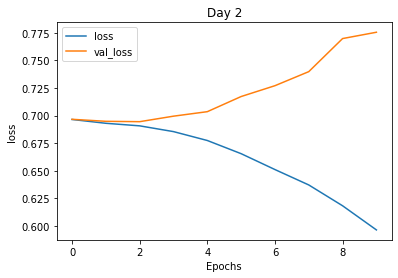

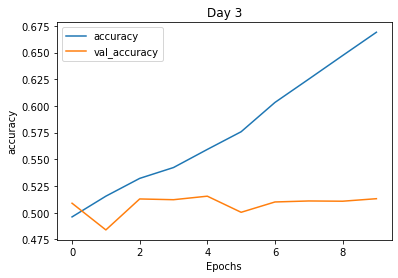

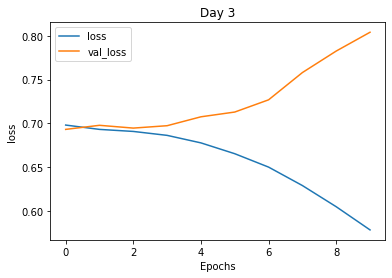

In [297]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric, title):
    plt.figure()
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.title(title)
    plt.savefig(f"./figures/{metric}_{title}.png")

for day, history in enumerate(histories.values()):
    plot_graphs(history, "accuracy", f"Day {day}")
    plot_graphs(history, "loss", f"Day {day}")

## Unigram baseline
This is an attempt at a baseline using a pipeline of unigram features with a Random Forest Classifier

In [191]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline

X = sec8_df['text']
y = sec8_df.loc[:, ['target_day1open_day1close_ppc', 
                'target_day1open_day2close_ppc', 
                'target_day1open_day3close_ppc', 
                'target_dayneg1close_day1open_ppc']]
y.columns = ['n0', 'n1', 'n2', 'n3']
X_train_rf = X.iloc[train_idx]
X_val_rf = X.iloc[val_idx]
X_test_rf = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_val = y.iloc[val_idx]
y_test = y.iloc[test_idx]

CPU times: user 4.85 ms, sys: 1.28 ms, total: 6.13 ms
Wall time: 5.4 ms


In [171]:
# Create pipeline
from sklearn.model_selection import permutation_test_score
for day in ['n0', 'n1', 'n2', 'n3']:
    pipe = Pipeline([('count', CountVectorizer(stop_words="english")), 
                     ('feature_selection', SelectKBest(mutual_info_classif, k=2320)), 
                     ('clf', RandomForestClassifier(max_depth=10))])
    pipe.fit(X_train_rf, y_train_rf[day])
    y_pred_test = pipe.predict(X_test_rf)
    y_pred_train = pipe.predict(X_train_rf)
    print(f"Test classification score, day {day}")
    print(classification_report(y_test[day], np.where(y_pred_test > 0.5, 1, 0)))
    print(accuracy_score(y_test[day], np.where(y_pred_test > 0.5, 1, 0)))
    print(f"Training accuracy score, day {day}")
    print(accuracy_score(y_train[day], np.where(y_pred_train > 0.5, 1, 0)))
    score = permutation_test_score(pipe, X_test_rf, y_test_rf)

Test classification score, day n0
              precision    recall  f1-score   support

           0       0.55      0.85      0.66      2103
           1       0.47      0.16      0.24      1774

    accuracy                           0.53      3877
   macro avg       0.51      0.51      0.45      3877
weighted avg       0.51      0.53      0.47      3877

0.5344338405984008
Training accuracy score, day n0
0.654026026840179
Test classification score, day n1
              precision    recall  f1-score   support

           0       0.54      0.90      0.68      2096
           1       0.48      0.11      0.18      1781

    accuracy                           0.54      3877
   macro avg       0.51      0.50      0.43      3877
weighted avg       0.51      0.54      0.45      3877

0.5362393603301522
Training accuracy score, day n1
0.6398942659617731
Test classification score, day n2
              precision    recall  f1-score   support

           0       0.54      0.93      0.68      2